This notebook shows the application of LSTM to predict the global temperature map.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn

from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
cwd = os.getcwd()
# train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
# test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

In [5]:
X_train_xr, X_length = load_and_build_X("data/INPUTS_DICT_cumsum.pkl")
y_train_xr, y_length = load_and_build_Y("data/cold_spells")
X_test_xr = build_X_test_ssp245()
y_test_xr = build_y_test_ssp245("data/cold_spells")

#### select relevant variables

In [6]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2n"].mean(['latitude', 'longitude']).data,
                           "CH4": X_train_xr["CH4"].mean(['latitude', 'longitude']).data
                          }, index=X_train_xr["CO2n"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2n"].mean(['latitude', 'longitude']).data,
                           "CH4": X_test_xr["CH4"].mean(['latitude', 'longitude']).data
                          }, index=X_test_xr["CO2n"].coords['time'].data)

y_train_df = y_train_xr.stack({"stacked": ("latitude", "longitude")})
y_test_df = y_test_xr.stack({"stacked": ("latitude", "longitude")})

y_train_df = pd.DataFrame(y_train_df.to_pandas())
y_test_df = pd.DataFrame(y_test_df.to_pandas())

#### Data normalization

In [7]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()


# y_train_df, y_test_df: (N, 12960)
y_mean = y_train_df.mean(axis=0)     # (12960,)
y_std  = y_train_df.std(axis=0)

# avoid divide by zero
y_std[y_std == 0] = 1.0

y_train_norm = (y_train_df - y_mean) / y_std
y_test_norm  = (y_test_df  - y_mean) / y_std

# use these for training
y_train = y_train_norm.to_numpy()
y_test  = y_test_norm.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)


(753, 2) (753, 12960) (86, 2)


#### Reshape data to feed into the LSTM model

The LSTM needs data with the format of **[samples, time steps, features]**

Here the lag time step is set to **5**

In [8]:
start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 5
X_train_all = []
y_train_all = []

for i in range(len(X_length)):
    
    X_subset = X_train[start[i]:end[i],:]
    y_subset = y_train[start[i]:end[i],:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([y_subset[i+slider-1] for i in range(0, X_length[i]-slider+1)])
    
    X_train_all.append(X_subset)
    y_train_all.append(y_subset)
    
X_train = np.concatenate(X_train_all,axis=0)
y_train = np.concatenate(y_train_all,axis=0)
X_test  = np.array([X_test[i:i+slider] for i in range(0, X_test.shape[0]-slider+1)])
print(X_train.shape,y_train.shape,X_test.shape)

(729, 5, 2) (729, 12960) (82, 5, 2)


In [9]:
# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), \
                                               torch.FloatTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test))

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

### 2. Define the LSTM structure

In [10]:
# set hyperparameters
n_neuron       = 64
activation     = 'ReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [11]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation="ReLU", num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            getattr(nn, activation)(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)        # [batch, seq_len, hidden]
        x = out[:, -1, :]            # last timestep output
        x = self.fc(x)
        return x

model = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=n_neuron,
    output_size=y_train.shape[-1],
    activation = activation,
    num_layers=2
)


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [14]:
model.to(device)

LSTMModel(
  (lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=12960, bias=True)
  )
)

### 3. Train & save the NN model

In [65]:
from utils import pytorch_train
# we will be using the same function as seen in the CNN_example.ipynb notebook 

train_losses_mse, val_losses_mse = pytorch_train(model, optimizer, criterion = criterion, 
                                                 device = device, 
                                                 train_loader = train_loader, val_loader = val_loader, 
                                                 num_epochs = num_epochs)

Epoch 1/50, Train Loss: 1.0111, Val Loss: 1.0719
Epoch 2/50, Train Loss: 0.9898, Val Loss: 1.0180
Epoch 3/50, Train Loss: 0.8646, Val Loss: 0.7730
Epoch 4/50, Train Loss: 0.6557, Val Loss: 0.5910
Epoch 5/50, Train Loss: 0.5605, Val Loss: 0.5329
Epoch 6/50, Train Loss: 0.5194, Val Loss: 0.5146
Epoch 7/50, Train Loss: 0.5070, Val Loss: 0.5006
Epoch 8/50, Train Loss: 0.5002, Val Loss: 0.4976
Epoch 9/50, Train Loss: 0.4970, Val Loss: 0.4939
Epoch 10/50, Train Loss: 0.4955, Val Loss: 0.4941
Epoch 11/50, Train Loss: 0.4952, Val Loss: 0.4931
Epoch 12/50, Train Loss: 0.4946, Val Loss: 0.4932
Epoch 13/50, Train Loss: 0.4941, Val Loss: 0.4925
Epoch 14/50, Train Loss: 0.4936, Val Loss: 0.4922
Epoch 15/50, Train Loss: 0.4931, Val Loss: 0.4917
Epoch 16/50, Train Loss: 0.4926, Val Loss: 0.4913
Epoch 17/50, Train Loss: 0.4921, Val Loss: 0.4909
Epoch 18/50, Train Loss: 0.4915, Val Loss: 0.4905
Epoch 19/50, Train Loss: 0.4910, Val Loss: 0.4901
Epoch 20/50, Train Loss: 0.4905, Val Loss: 0.4897
Epoch 21/

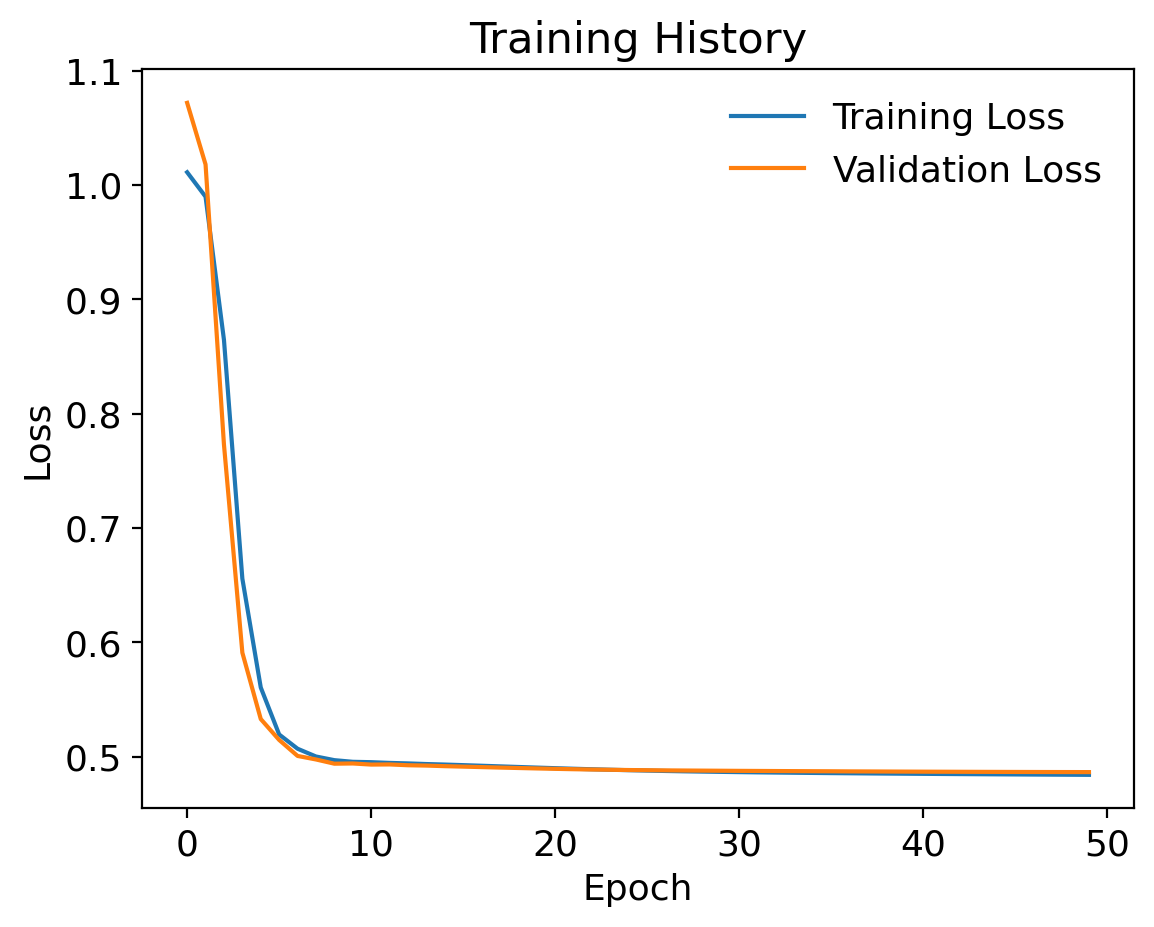

In [66]:
plot_history(train_losses_mse, val_losses_mse)

In [16]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [76]:
# Save the model weights to a pth file.
torch.save(model.state_dict(), os.path.join(model_path,'LSTM_model_weights.pth'))

### 4. Evaluate the trained model

In [17]:
# make new model instances for evaluation (best practice)
model_eval = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=n_neuron,
    output_size=y_train.shape[-1],
    num_layers=2
)

# reload the saved model weights
state_dict = torch.load(os.path.join(model_path,'LSTM_model_weights.pth'), weights_only=True)
model_eval.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

model_eval.to(device).eval()
predictions = []
with torch.no_grad():
   for batch_X, in test_loader:
       batch_X = batch_X.to(device)
       outputs = model_eval(batch_X)
       predictions.append(outputs.cpu().numpy())

In [19]:
# Ensure these are numpy arrays, not pandas Series
y_mean_arr = np.asarray(y_mean)    # shape (12960,)
y_std_arr  = np.asarray(y_std)     # shape (12960,)

# --- Step 1: get raw normalized predictions ---
y_test_pre = np.concatenate(predictions, axis=0)   # (N_test, 12960)

# --- Step 2: denormalize with proper broadcasting ---
y_test_pre = y_test_pre * y_std_arr[None, :] + y_mean_arr[None, :]
# still shape (N_test, 12960)

# --- Step 3: reshape to 2D maps ---
y_test_pre = y_test_pre.reshape(-1, 90, 144)

# --- Step 4: wrap into xarray Dataset ---
y_test_pre = xr.DataArray(y_test_pre, 
                          dims=['time','latitude','longitude'],
                          coords={
                              'time': np.arange(2017, 2099),
                              'latitude': X_test_xr.latitude.values,
                              'longitude': X_test_xr.longitude.values
                          },
                          name='tas')


y_test_xr['time'] = np.arange(2015, 2101)

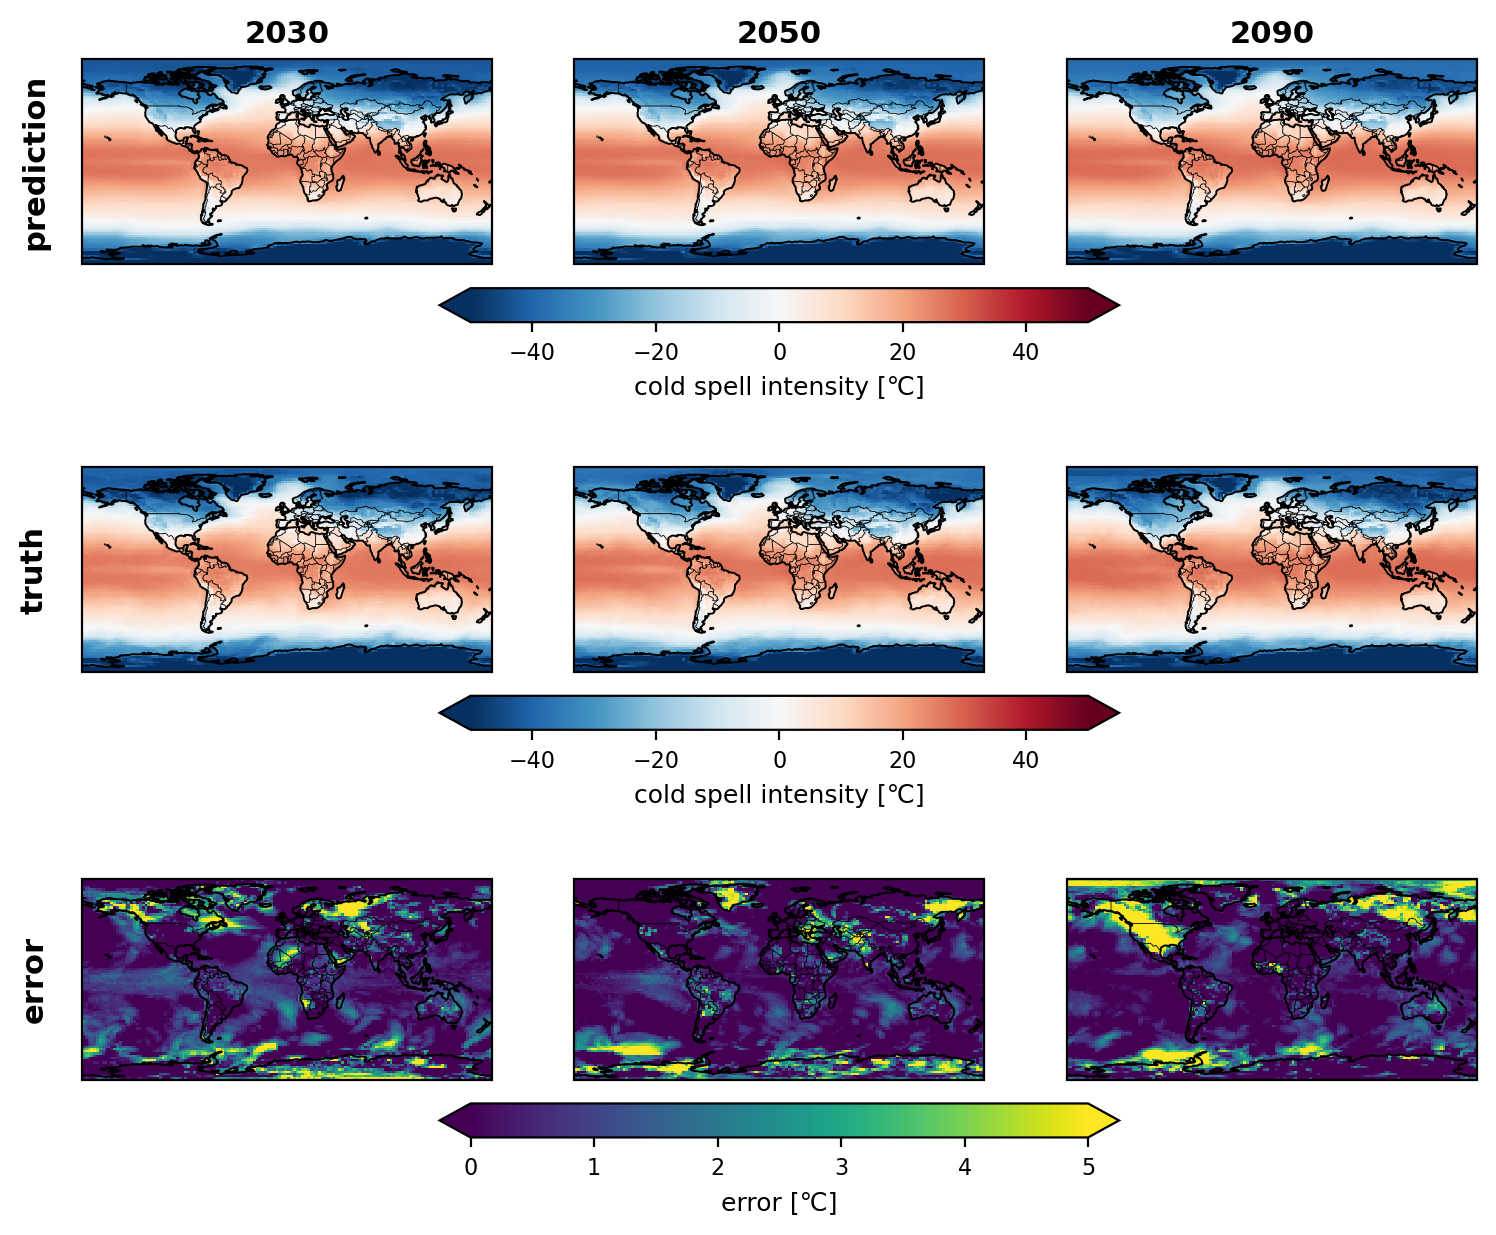

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

yrs = [2030, 2050, 2090]

# value ranges
vmin, vmax   = -50, 50        # pred & truth
rvmin, rvmax = 0, 5          # RMSE range
cmap = "RdBu_r"

nrows = 3
ncols = len(yrs)

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(3.*ncols, 2.5*nrows),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

row_titles = ["prediction", "truth", "error"]

# store a mappable for each row
mappables = [None] * nrows

for j, year in enumerate(yrs):

    da_pred = y_test_pre.sel(time=year)
    da_true = y_test_xr.sel(time=year)
    da_rmse = da_pred - da_true

    for row, da in enumerate([da_pred, da_true, da_rmse]):
        ax = axes[row, j]

        # choose ranges
        if row < 2:
            vmin_row, vmax_row = vmin, vmax
            cmap_row = cmap
        else:
            vmin_row, vmax_row = rvmin, rvmax
            cmap_row = "viridis"

        # plot
        m = da.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            vmin=vmin_row, vmax=vmax_row,
            cmap=cmap_row,
            add_colorbar=False
        )

        # save first mappable per row
        if mappables[row] is None:
            mappables[row] = m

        # coastlines
        ax.coastlines(linewidth=0.7)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)

        # remove axis labels
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("")

        # column titles (years)
        if row == 0:
            ax.set_title(str(year), fontweight="bold", fontsize=11)

        # row labels
        if j == 0:
            ax.text(
                -0.08, 0.5, row_titles[row],
                transform=ax.transAxes,
                rotation=90,
                va="center", ha="right",
                fontsize=11, fontweight="bold"
            )

# colorbars for each row
for row in range(nrows):
    cbar = fig.colorbar(
        mappables[row],
        ax=axes[row, :],
        orientation="horizontal",
        fraction=0.1,
        pad=0.07,
        extend = "both"
    )
    cbar.ax.tick_params(labelsize=8)

    # add labels with [K]
    if row == 0:
        cbar.set_label("cold spell intensity [℃]", fontsize=9)
    elif row == 1:
        cbar.set_label("cold spell intensity [℃]", fontsize=9)
    else:
        cbar.set_label("error [℃]", fontsize=9)


Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

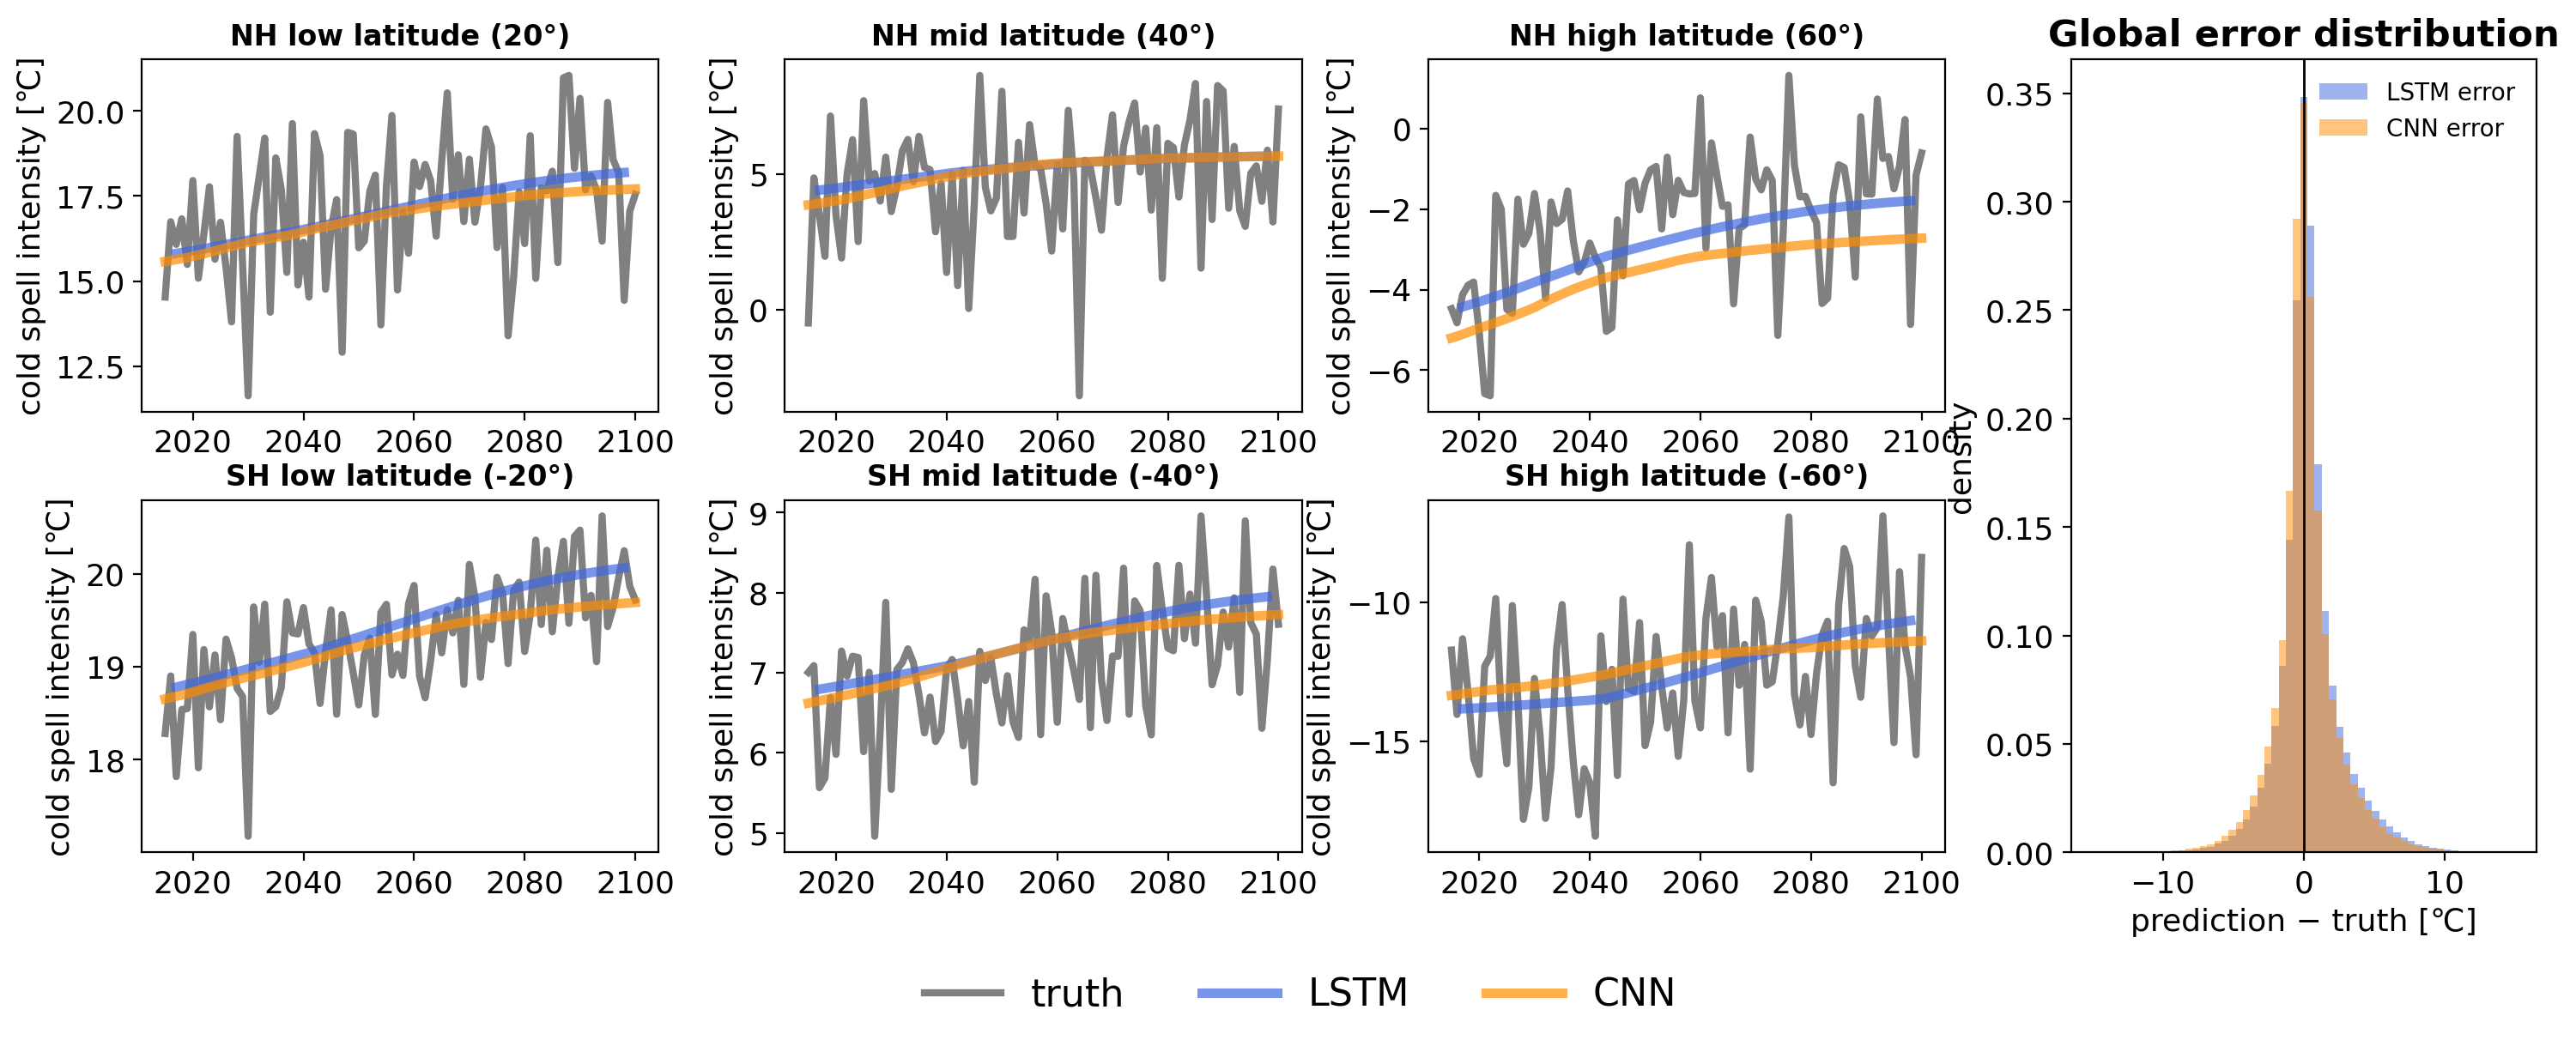

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.gridspec import GridSpec

# Load CNN prediction
y_text_cnn = xr.open_dataarray("CNN_coldspell_prediction.nc")

# Latitude selections
north_lats = [20, 40, 60]     # low, mid, high
south_lats = [-20, -40, -60]

lon = 0
lon360 = lon % 360

# ---------- Figure + GridSpec (2x4; last column is error distribution) ----------
fig = plt.figure(figsize=(18, 6))
gs = GridSpec(2, 4, width_ratios=[1, 1, 1, 0.9], wspace=0.25, hspace=0.25)

# 2x3 array for time series axes
axes = np.empty((2, 3), dtype=object)
for i in range(2):
    for j in range(3):
        axes[i, j] = fig.add_subplot(gs[i, j])

# Single axis spanning both rows for error distribution
ax_hist = fig.add_subplot(gs[:, 3])

labels = ["low latitude", "mid latitude", "high latitude"]

# Colors (nice, readable palette)
c_truth = "grey"
c_lstm  = "royalblue"
c_cnn   = "darkorange"
lw = 4.0

# ========== Northern Hemisphere ==========
for j, lat in enumerate(north_lats):
    ax = axes[0, j]

    ts_true = y_test_xr.sel(latitude=lat, longitude=lon360, method="nearest")
    ts_lstm = y_test_pre.sel(latitude=lat, longitude=lon360, method="nearest")
    ts_cnn  = y_text_cnn.sel(latitude=lat, longitude=lon360, method="nearest")

    ts_true.plot(ax=ax, color=c_truth, linewidth=lw-1, label="truth")
    ts_lstm.plot(ax=ax, color=c_lstm,  linewidth=lw,   alpha=0.7, label="LSTM")
    ts_cnn.plot(ax=ax,  color=c_cnn,   linewidth=lw,   alpha=0.7, label="CNN")

    ax.set_title(f"NH {labels[j]} ({lat}°)", fontsize=12, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("cold spell intensity [℃]")

# ========== Southern Hemisphere ==========
for j, lat in enumerate(south_lats):
    ax = axes[1, j]

    ts_true = y_test_xr.sel(latitude=lat, longitude=lon360, method="nearest")
    ts_lstm = y_test_pre.sel(latitude=lat, longitude=lon360, method="nearest")
    ts_cnn  = y_text_cnn.sel(latitude=lat, longitude=lon360, method="nearest")

    ts_true.plot(ax=ax, color=c_truth, linewidth=lw-1, label="truth")
    ts_lstm.plot(ax=ax, color=c_lstm,  linewidth=lw,   alpha=0.7, label="LSTM")
    ts_cnn.plot(ax=ax,  color=c_cnn,   linewidth=lw,   alpha=0.7, label="CNN")

    ax.set_title(f"SH {labels[j]} ({lat}°)", fontsize=12, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("cold spell intensity [℃]")

# ---------- Error distribution panel (global, all times and gridpoints) ----------
err_lstm = (y_test_pre - y_test_xr).values.flatten()
err_cnn  = (y_text_cnn  - y_test_xr).values.flatten()

bins = np.linspace(-15, 15, 60)

ax_hist.hist(err_lstm, bins=bins, density=True, alpha=0.5,
             color=c_lstm, label="LSTM error")
ax_hist.hist(err_cnn,  bins=bins, density=True, alpha=0.5,
             color=c_cnn,  label="CNN error")

ax_hist.axvline(0, color="k", linewidth=1)
ax_hist.set_xlabel("prediction − truth [℃]")
ax_hist.set_ylabel("density")
ax_hist.set_title("Global error distribution", fontweight="bold")
ax_hist.legend(fontsize=10)

# ---------- Single legend for time-series lines ----------
handles, labels_legend = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels_legend,
    loc="lower center",
    ncol=3,
    fontsize=16,
    bbox_to_anchor=(0.5, -0.08)
)



In [48]:
err_lstm = (y_test_pre - y_test_xr).values.flatten()
err_cnn  = (y_text_cnn - y_test_xr).values.flatten()

metrics = {
    "RMSE": (
        np.sqrt(np.mean(err_lstm**2)),
        np.sqrt(np.mean(err_cnn**2))
    ),
    "MAE": (
        np.mean(np.abs(err_lstm)),
        np.mean(np.abs(err_cnn))
    ),
    "Std Error": (
        np.std(err_lstm),
        np.std(err_cnn)
    ),
    "IQR": (
        np.percentile(err_lstm,75) - np.percentile(err_lstm,25),
        np.percentile(err_cnn,75) - np.percentile(err_cnn,25)
    ),
    "Bias": (
        np.mean(err_lstm),
        np.mean(err_cnn)
    )
}

for k,(l,c) in metrics.items():
    print(f"{k:12s}  LSTM={l:.3f},  CNN={c:.3f}")


RMSE          LSTM=2.249,  CNN=2.197
MAE           LSTM=1.492,  CNN=1.467
Std Error     LSTM=2.215,  CNN=2.193
IQR           LSTM=1.789,  CNN=1.768
Bias          LSTM=0.391,  CNN=0.122


Finally we check whether the ML model can capture the time series of global average temperature 

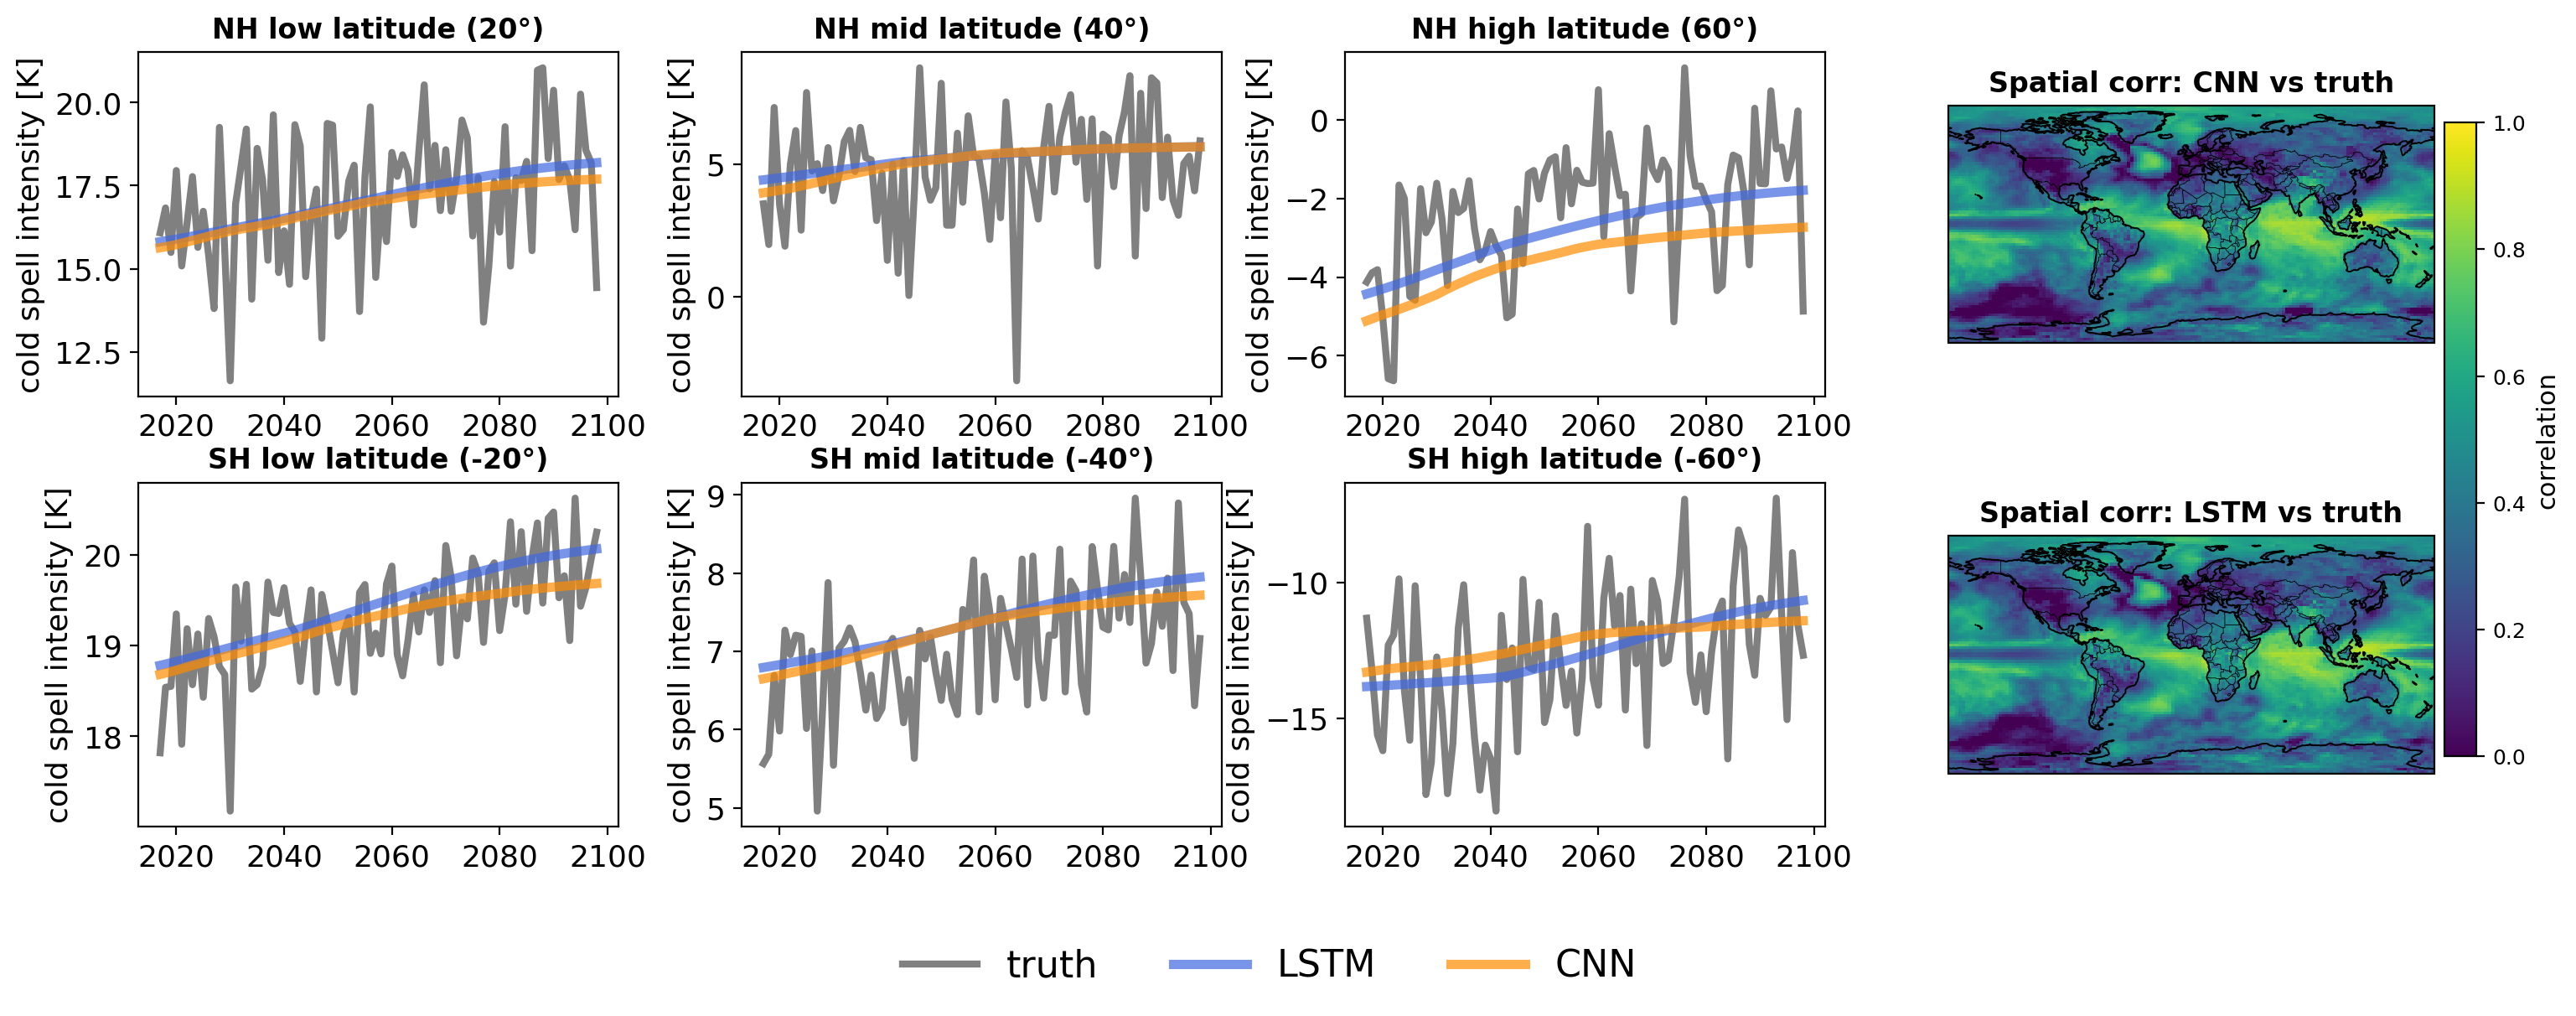

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- If any of these are Datasets, pull out the main variable (e.g. "tas") ---
def to_da(obj):
    if isinstance(obj, xr.DataArray):
        return obj
    else:
        # adjust "tas" if your var name is different
        return obj[list(obj.data_vars)[0]]

da_truth = to_da(y_test_xr)
da_cnn   = to_da(y_text_cnn)
da_lstm  = to_da(y_test_pre)

# Align in time/space just in case
da_cnn, da_lstm, da_truth = xr.align(da_cnn, da_lstm, da_truth, join="inner")

# ---------- Spatial correlations ----------
corr_cnn  = xr.corr(da_cnn,  da_truth, dim="time")
corr_lstm = xr.corr(da_lstm, da_truth, dim="time")

# ---------- Figure + GridSpec (2 time-series rows + 2 corr maps) ----------
fig = plt.figure(figsize=(18, 6))
gs = GridSpec(2, 4, width_ratios=[1, 1, 1, 1.1], wspace=0.25, hspace=0.25)

# time-series axes (2x3)
axes = np.empty((2, 3), dtype=object)
for i in range(2):
    for j in range(3):
        axes[i, j] = fig.add_subplot(gs[i, j])

# correlation map axes (CNN top, LSTM bottom)
ax_corr_cnn  = fig.add_subplot(gs[0, 3], projection=ccrs.PlateCarree())
ax_corr_lstm = fig.add_subplot(gs[1, 3], projection=ccrs.PlateCarree())

# ---------------------------------------------------------------------
#                     TIME-SERIES PART (your existing code)
# ---------------------------------------------------------------------
north_lats = [20, 40, 60]
south_lats = [-20, -40, -60]
lon = 0
lon360 = lon % 360

labels = ["low latitude", "mid latitude", "high latitude"]

c_truth = "grey"
c_lstm  = "royalblue"
c_cnn   = "darkorange"
lw = 4.0

# ========== Northern Hemisphere ==========
for j, lat in enumerate(north_lats):
    ax = axes[0, j]

    ts_true = da_truth.sel(latitude=lat, longitude=lon360, method="nearest")
    ts_lstm = da_lstm.sel(latitude=lat, longitude=lon360, method="nearest")
    ts_cnn  = da_cnn.sel(latitude=lat, longitude=lon360, method="nearest")

    ts_true.plot(ax=ax, color=c_truth, linewidth=lw-1, label="truth")
    ts_lstm.plot(ax=ax, color=c_lstm,  linewidth=lw,   alpha=0.7, label="LSTM")
    ts_cnn.plot(ax=ax,  color=c_cnn,   linewidth=lw,   alpha=0.7, label="CNN")

    ax.set_title(f"NH {labels[j]} ({lat}°)", fontsize=12, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("cold spell intensity [K]")

# ========== Southern Hemisphere ==========
for j, lat in enumerate(south_lats):
    ax = axes[1, j]

    ts_true = da_truth.sel(latitude=lat, longitude=lon360, method="nearest")
    ts_lstm = da_lstm.sel(latitude=lat, longitude=lon360, method="nearest")
    ts_cnn  = da_cnn.sel(latitude=lat, longitude=lon360, method="nearest")

    ts_true.plot(ax=ax, color=c_truth, linewidth=lw-1, label="truth")
    ts_lstm.plot(ax=ax, color=c_lstm,  linewidth=lw,   alpha=0.7, label="LSTM")
    ts_cnn.plot(ax=ax,  color=c_cnn,   linewidth=lw,   alpha=0.7, label="CNN")

    ax.set_title(f"SH {labels[j]} ({lat}°)", fontsize=12, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("cold spell intensity [K]")

# single legend for the time series
handles, labels_legend = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels_legend,
    loc="lower center",
    ncol=3,
    fontsize=16,
    bbox_to_anchor=(0.5, -0.08)
)

# ---------------------------------------------------------------------
#                     CORRELATION MAPS
# ---------------------------------------------------------------------
vmin, vmax = 0.0, 1.0

# CNN vs truth
m1 = corr_cnn.plot(
    ax=ax_corr_cnn,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    vmin=vmin, vmax=vmax,
    add_colorbar=False
)
ax_corr_cnn.coastlines(linewidth=0.7)
ax_corr_cnn.add_feature(cfeature.BORDERS, linewidth=0.3)
ax_corr_cnn.set_title("Spatial corr: CNN vs truth", fontsize=12, fontweight="bold")

# LSTM vs truth
m2 = corr_lstm.plot(
    ax=ax_corr_lstm,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    vmin=vmin, vmax=vmax,
    add_colorbar=False
)
ax_corr_lstm.coastlines(linewidth=0.7)
ax_corr_lstm.add_feature(cfeature.BORDERS, linewidth=0.3)
ax_corr_lstm.set_title("Spatial corr: LSTM vs truth", fontsize=12, fontweight="bold")

for ax in [ax_corr_cnn, ax_corr_lstm]:
    ax.set_xlabel("")
    ax.set_ylabel("")

# shared colorbar for the two correlation panels
cbar = fig.colorbar(
    m2,
    ax=[ax_corr_cnn, ax_corr_lstm],
    orientation="vertical",
    fraction=0.06,
    pad=0.02
)
cbar.set_label("correlation", fontsize=11)
cbar.ax.tick_params(labelsize=9)


In [24]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# --- Ensure DataArray objects ---
def to_da(obj):
    if isinstance(obj, xr.DataArray):
        return obj
    else:
        return obj[list(obj.data_vars)[0]]

da_truth = to_da(y_test_xr)
da_cnn   = to_da(y_text_cnn)
da_lstm  = to_da(y_test_pre)

# Align domains
da_cnn, da_lstm, da_truth = xr.align(da_cnn, da_lstm, da_truth, join="inner")

# --- Define regions (same as before) ---
regions = {
    "Tropics\n(30S–30N)"   : slice(-30, 30),
    "NH mid-lat\n(30–60N)" : slice(30, 60),
    "Arctic\n(60–90N)"     : slice(60, 90),
    "Antarctica\n(60–90S)" : slice(-90, -60),
}

def region_metrics(pred_da, truth_da, lat_slice):
    """Return RMSE, corr, bias for one region."""
    t_reg = truth_da.sel(latitude=lat_slice)
    p_reg = pred_da.sel(latitude=lat_slice)

    t_vals = t_reg.values.ravel()
    p_vals = p_reg.values.ravel()
    mask = np.isfinite(t_vals) & np.isfinite(p_vals)
    t_vals = t_vals[mask]
    p_vals = p_vals[mask]

    # RMSE
    rmse = np.sqrt(np.mean((p_vals - t_vals)**2))
    # correlation
    if t_vals.size > 1:
        corr = np.corrcoef(t_vals, p_vals)[0, 1]
    else:
        corr = np.nan
    # mean bias
    bias = np.mean(p_vals - t_vals)

    return rmse, corr, bias

# collect metrics in dicts
rmse_cnn, rmse_lstm = [], []
corr_cnn, corr_lstm = [], []
bias_cnn, bias_lstm = [], []

region_names = list(regions.keys())

for name, lat_slice in regions.items():
    r_cnn, c_cnn, b_cnn   = region_metrics(da_cnn,  da_truth, lat_slice)
    r_lstm, c_lstm, b_lstm = region_metrics(da_lstm, da_truth, lat_slice)

    rmse_cnn.append(r_cnn)
    rmse_lstm.append(r_lstm)
    corr_cnn.append(c_cnn)
    corr_lstm.append(c_lstm)
    bias_cnn.append(b_cnn)
    bias_lstm.append(b_lstm)


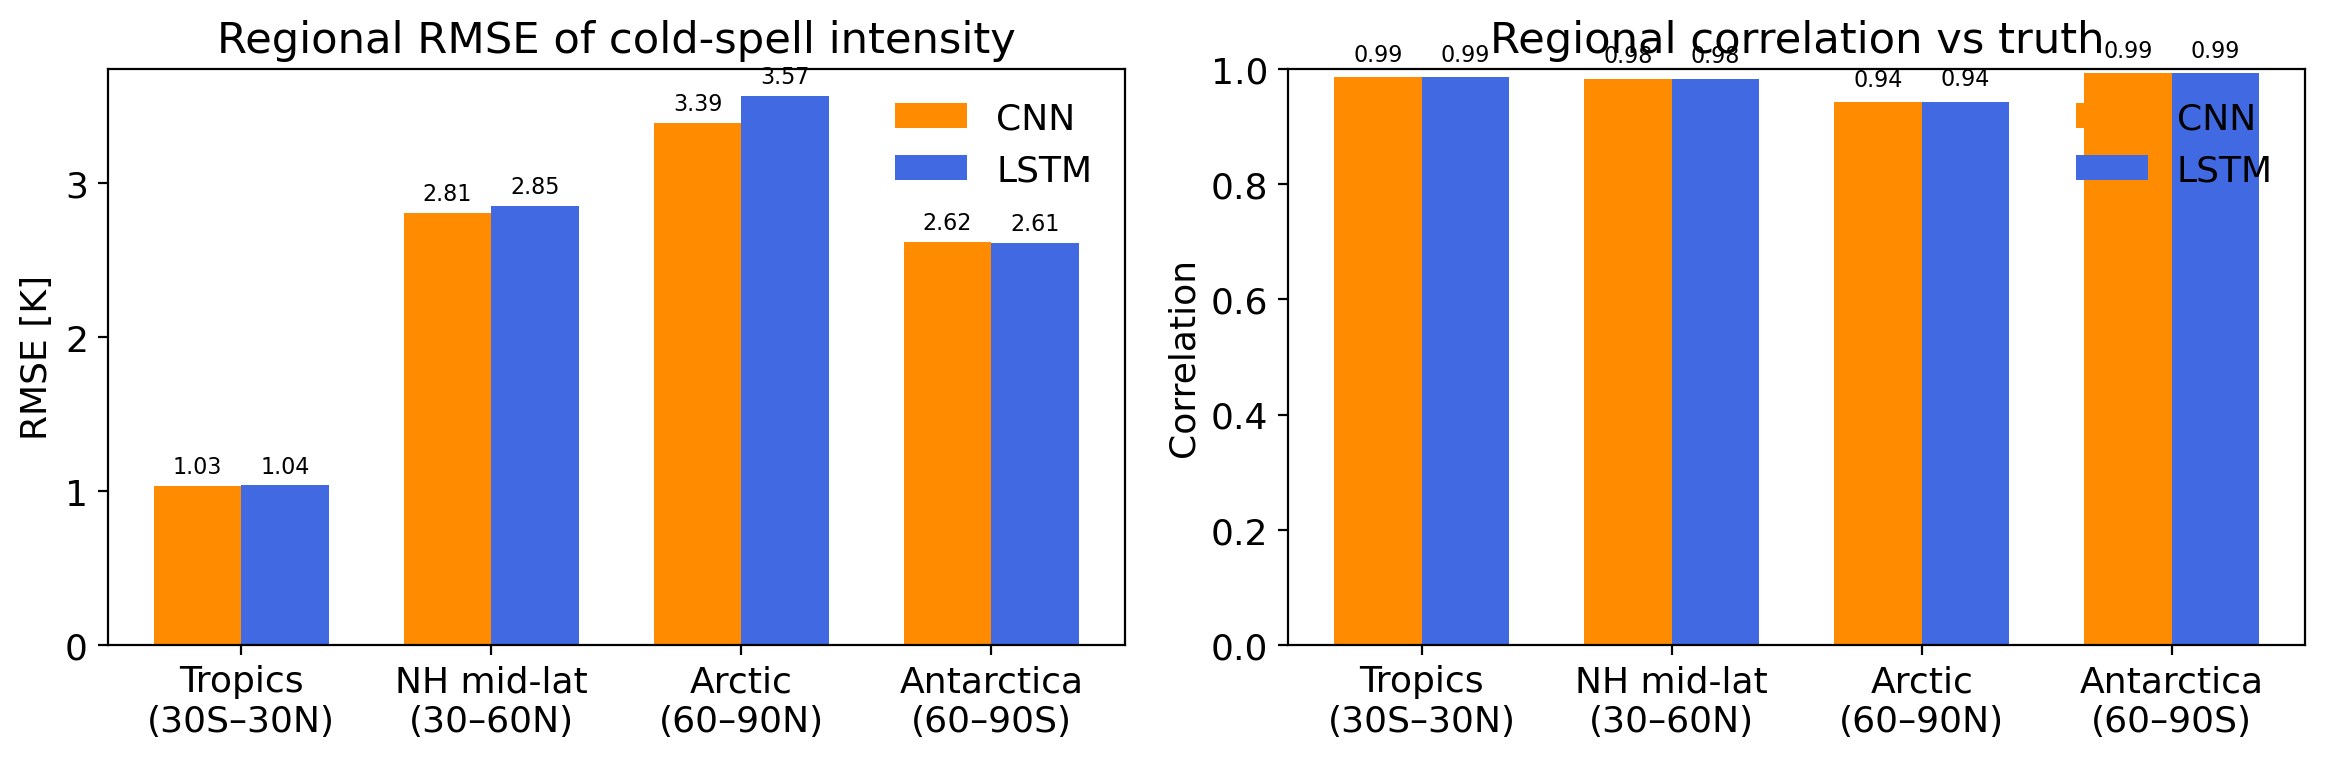

In [25]:
x = np.arange(len(region_names))   # positions for regions
width = 0.35                       # bar width

c_cnn  = "darkorange"
c_lstm = "royalblue"

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# -------- RMSE panel --------
ax = axes[0]
ax.bar(x - width/2, rmse_cnn, width, label="CNN",  color=c_cnn)
ax.bar(x + width/2, rmse_lstm, width, label="LSTM", color=c_lstm)

ax.set_xticks(x)
ax.set_xticklabels(region_names, rotation=0)
ax.set_ylabel("RMSE [K]")
ax.set_title("Regional RMSE of cold-spell intensity")
ax.legend()

# optional: show numbers on top
for i, v in enumerate(rmse_cnn):
    ax.text(x[i] - width/2, v + 0.05, f"{v:.2f}", ha="center", va="bottom", fontsize=8)
for i, v in enumerate(rmse_lstm):
    ax.text(x[i] + width/2, v + 0.05, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

# -------- Correlation panel --------
ax2 = axes[1]
ax2.bar(x - width/2, corr_cnn, width, label="CNN",  color=c_cnn)
ax2.bar(x + width/2, corr_lstm, width, label="LSTM", color=c_lstm)

ax2.set_xticks(x)
ax2.set_xticklabels(region_names, rotation=0)
ax2.set_ylabel("Correlation")
ax2.set_ylim(0, 1.0)
ax2.set_title("Regional correlation vs truth")
ax2.legend()

for i, v in enumerate(corr_cnn):
    ax2.text(x[i] - width/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=8)
for i, v in enumerate(corr_lstm):
    ax2.text(x[i] + width/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


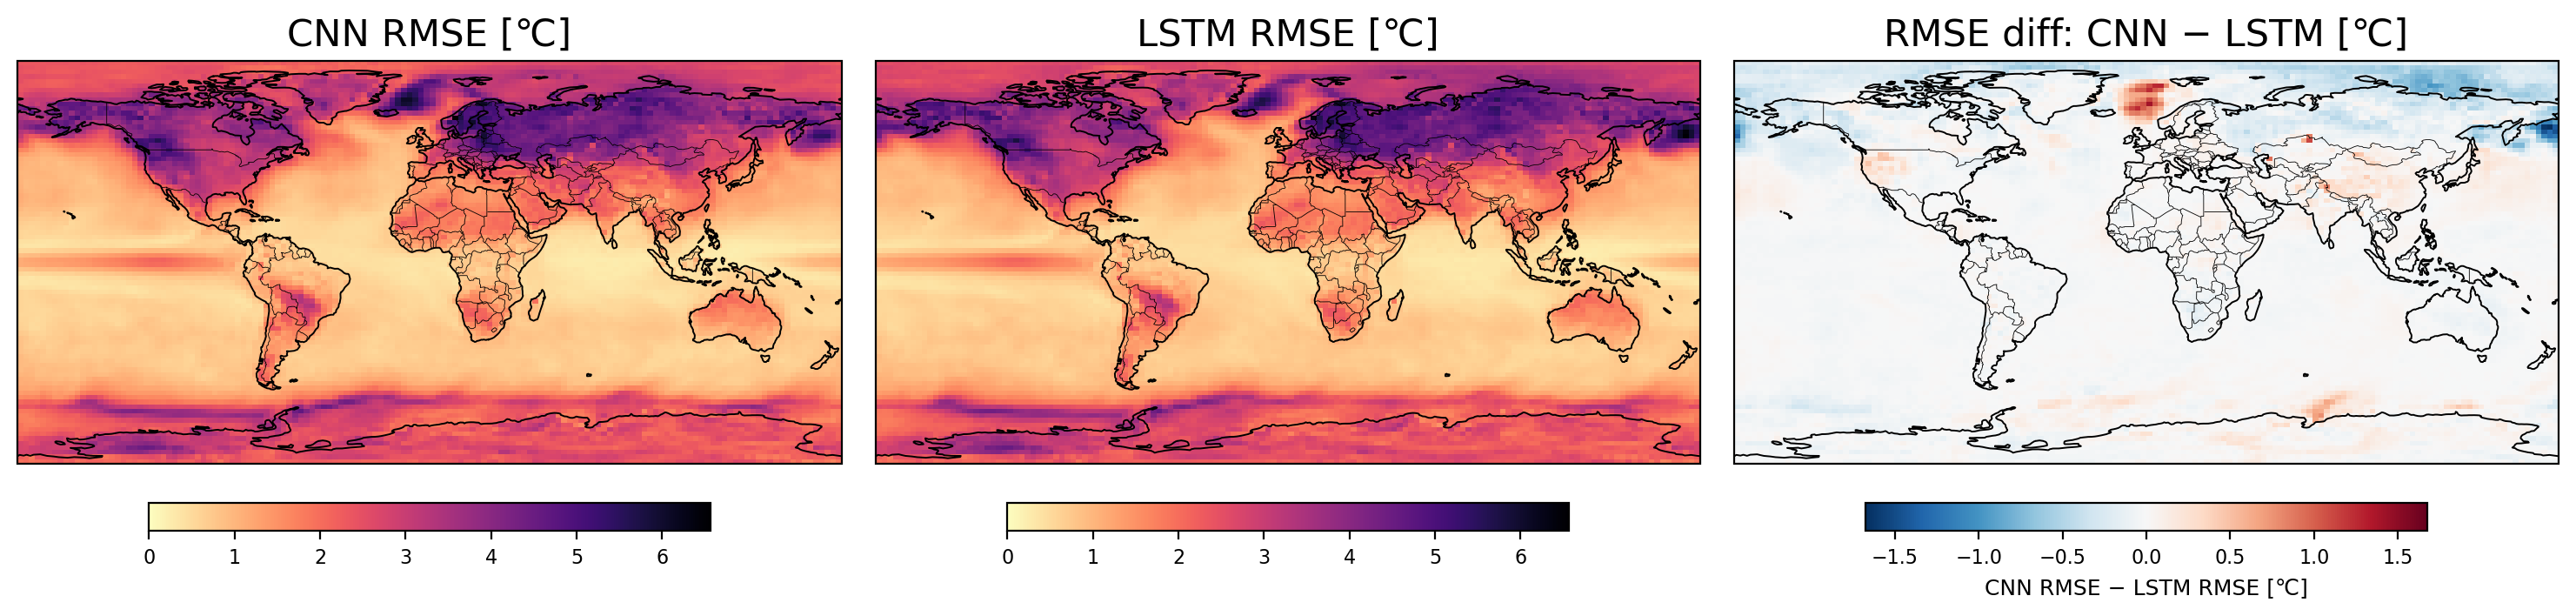

In [29]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- 1. Make sure everything is DataArray ---

def to_da(obj):
    if isinstance(obj, xr.DataArray):
        return obj
    else:
        # if Dataset, take first data_var (or specify name if you prefer)
        return obj[list(obj.data_vars)[0]]

da_truth = to_da(y_test_xr)
da_cnn   = to_da(y_text_cnn)
da_lstm  = to_da(y_test_pre)

# align on common time/lat/lon just in case
da_cnn, da_lstm, da_truth = xr.align(da_cnn, da_lstm, da_truth, join="inner")

# --- 2. Compute RMSE maps over time for each model ---

err_cnn  = da_cnn  - da_truth
err_lstm = da_lstm - da_truth

rmse_cnn  = np.sqrt((err_cnn**2).mean(dim="time"))
rmse_lstm = np.sqrt((err_lstm**2).mean(dim="time"))

# RMSE difference: CNN RMSE - LSTM RMSE
# < 0  → CNN better;  > 0 → LSTM better
rmse_diff = rmse_cnn - rmse_lstm

# --- 3. Plot: RMSE CNN, RMSE LSTM, and Difference ---

proj = ccrs.PlateCarree()

fig, axes = plt.subplots(
    nrows=1, ncols=3,
    figsize=(15, 4),
    subplot_kw={"projection": proj}
)

vmax_rmse = float(max(rmse_cnn.max(), rmse_lstm.max()))
vmin_rmse = 0

# Panel 1: CNN RMSE
m0 = rmse_cnn.plot(
    ax=axes[0],
    transform=proj,
    cmap="magma_r",
    vmin=vmin_rmse, vmax=vmax_rmse,
    add_colorbar=False
)
axes[0].coastlines(linewidth=0.7)
axes[0].add_feature(cfeature.BORDERS, linewidth=0.3)
axes[0].set_title("CNN RMSE [℃]")
axes[0].set_xlabel(""); axes[0].set_ylabel("")

cbar0 = fig.colorbar(m0, ax=axes[0], orientation="horizontal", fraction=0.05, pad=0.07)
cbar0.ax.tick_params(labelsize=8)

# Panel 2: LSTM RMSE
m1 = rmse_lstm.plot(
    ax=axes[1],
    transform=proj,
    cmap="magma_r",
    vmin=vmin_rmse, vmax=vmax_rmse,
    add_colorbar=False
)
axes[1].coastlines(linewidth=0.7)
axes[1].add_feature(cfeature.BORDERS, linewidth=0.3)
axes[1].set_title("LSTM RMSE [℃]")
axes[1].set_xlabel(""); axes[1].set_ylabel("")

cbar1 = fig.colorbar(m1, ax=axes[1], orientation="horizontal", fraction=0.05, pad=0.07)
cbar1.ax.tick_params(labelsize=8)

# Panel 3: RMSE difference (CNN - LSTM)
vmax_diff = float(np.nanmax(np.abs(rmse_diff)))
m2 = rmse_diff.plot(
    ax=axes[2],
    transform=proj,
    cmap="RdBu_r",
    vmin=-vmax_diff, vmax=vmax_diff,
    add_colorbar=False
)
axes[2].coastlines(linewidth=0.7)
axes[2].add_feature(cfeature.BORDERS, linewidth=0.3)
axes[2].set_title("RMSE diff: CNN − LSTM [℃]")
axes[2].set_xlabel(""); axes[2].set_ylabel("")

cbar2 = fig.colorbar(m2, ax=axes[2], orientation="horizontal", fraction=0.05, pad=0.07)
cbar2.ax.tick_params(labelsize=8)
cbar2.set_label("CNN RMSE − LSTM RMSE [℃]", fontsize=9)

plt.tight_layout()
plt.show()
